In [1]:
import math 
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Math
InteractiveShell.ast_node_interactivity = 'all'
from sympy.abc import beta
from scipy.optimize import curve_fit
from IPython.display import display, HTML
import pandas as pd

In [49]:
def linearF(x, m, b): return m*x+b

e = 1.602*10**-19

def PrintCarrierMobillity(a,b):
    print('Carrier Mobility = {0:1.3e} +/- {1:1.3e} cm^2/Vs'.format(
    1/(a.CarrierDensity[0]*e*b.resistivity[0])/100,
    np.sqrt((a.CarrierDensity[1]/(a.CarrierDensity[0]**2*e*b.resistivity[0])**2+(b.resistivity[1]/(a.CarrierDensity[0]*e*b.resistivity[0]**2))**2))/100
    ))
    return

def CarrierMobility(a,b):
    c = np.array([1/(a.CarrierDensity[0]*e*b.resistivity[0])/100,
                  np.sqrt((a.CarrierDensity[1]/(a.CarrierDensity[0]**2*e*b.resistivity[0])**2+(b.resistivity[1]/(a.CarrierDensity[0]*e*b.resistivity[0]**2))**2))/100
                 ])
    return c

In [50]:
class IV_BC:
    def __init__(self, name):
        self.name = name
        self.csv = name + '.csv'
        self.data = np.genfromtxt(self.csv, delimiter=',', skip_header = 1)
        self.popt, self.pcov = curve_fit(linearF, self.data[:,0], self.data[:,1])

        self.R = np.array([self.popt[0], np.sqrt(np.diag(self.pcov)[0])])
        
        w = 0.005
        h = 0.001
        l = 0.010
        A = w*h
        self.resistivity = self.R*A/l
        
    def plot(self):
        fig = plt.figure(figsize=(4,2.25), layout='constrained')
        ax1 = fig.add_subplot(1, 2, 1, title='', xlabel='I', ylabel='V', )
        ax1.scatter(self.data[:,0],self.data[:,1])
        ax2 = fig.add_subplot(1, 2, 2, title='line fit', xlabel='I', ylabel='V')
        ax2.scatter(self.data[:,0],self.data[:,1])
        ax2.plot(self.data[:,0], linearF(self.data[:,0], *self.popt), color='black')
        fig.suptitle(self.name)
        return

    def PrintR(self):
        print('R = {0:0.3e} +/- {1:0.3e} ohms'.format(self.popt[0], np.sqrt(np.diag(self.pcov)[0])))
        return
        
    def PrintResistivity(self): print('rho = {0:0.3e} +/- {1:0.3e} ohm-m'.format(self.resistivity[0], np.sqrt(np.diag(self.pcov)[0])*self.resistivity[1]))

In [51]:
class IV_wm:
    def __init__(self, name):
        self.name = name
        self.buf = np.empty((6,200,2))
        self.bufmag = np.empty((6,200,2))
        self.bufsum = np.zeros((200,2))
        self.bufmagsum = np.zeros((200,2))
        for i in range(6):
            csv = self.name + str(i) + '.csv'
            csvmag = self.name + '-Mag' + str(i) + '.csv'
            self.buf[i] = np.genfromtxt(csv, delimiter=',', skip_header = 1)
            self.bufsum += self.buf[i]
            self.bufmag[i] = np.genfromtxt(csvmag, delimiter=',', skip_header = 1)
            self.bufmagsum += self.bufmag[i]
        self.popt, self.pcov = curve_fit(linearF, self.bufmagsum[:,0], self.bufmagsum[:,1]-self.bufsum[:,1])
        if self.popt[0]>0: 
            self.MobileCarrier = 'Electron'
        else: self.MobileCarrier = 'Hole'
        self.R = abs(np.array([self.popt[0], np.sqrt(np.diag(self.pcov)[0])]))


        e = 1.602*10**-19
        h = 0.001
        B = np.array([0.0887, 0.0002])
        CarrierDensity = np.zeros(2)
        CarrierDensity[0] = B[0]/(e*h*self.R[0])/1000000
        CarrierDensity[1] = np.sqrt((B[1]/(e*h*self.R[0]))**2+(B[0]*self.R[1]/(e*h*self.R[0]**2))**2)/1000000        
        self.CarrierDensity = abs(CarrierDensity)

    def plot(self):
        fig = plt.figure(figsize=(8,2.25), layout='constrained')
        ax1 = fig.add_subplot(1, 4, 1, title='B=0', xlabel='I', ylabel='V', )
        ax1.scatter(self.bufsum[:,0],self.bufsum[:,1])
        ax2 = fig.add_subplot(1, 4, 2, title='B=r', xlabel='I', ylabel='V', )
        ax2.scatter(self.bufmagsum[:,0],self.bufmagsum[:,1])
        ax3 = fig.add_subplot(1, 4, 3, title='B-B0', xlabel='I', ylabel='V', )
        ax3.scatter(self.bufmagsum[:,0],self.bufmagsum[:,1]-self.bufsum[:,1])
        ax4 = fig.add_subplot(1, 4, 4, title='line fit', xlabel='I', ylabel='V')
        ax4.scatter(self.bufmagsum[:,0], self.bufmagsum[:,1]-self.bufsum[:,1])
        ax4.plot(self.bufmagsum[:,0], linearF(self.bufmagsum[:,0], *self.popt), color='black')
        fig.suptitle(self.name)
        return

    def PrintR(self):
        print('R = {0:0.3e} +/- {1:0.3e} ohms'.format(self.popt[0], np.sqrt(np.diag(self.pcov)[0])))
        return

    def PrintCarrierDensity(self):
        print('Carrier Density = {0:1.3e} +/- {1:1.3e} cm^-3'.format(self.CarrierDensity[0], self.CarrierDensity[1]))

R = 8.806e+01 +/- 5.218e-03 ohms
rho = 4.403e-02 +/- 1.361e-08 ohm-m


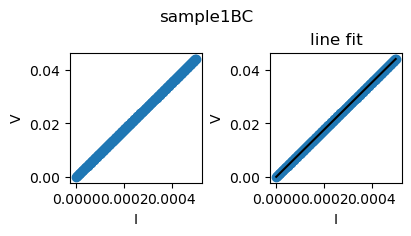

In [52]:
sample1BC = IV_BC('sample1BC')
sample1BC.plot()
sample1BC.PrintR()
sample1BC.PrintResistivity()

R = 7.761e-01 +/- 1.526e-03 ohms
Carrier Density = 7.135e+14 +/- 2.134e+12 cm^-3
Carrier Mobility = 1.987e+03 +/- 1.177e-01 cm^2/Vs


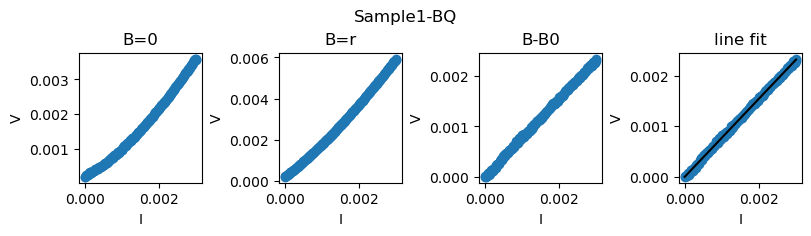

In [53]:
sample1BQ = IV_wm('Sample1-BQ')
sample1BQ.plot()
sample1BQ.PrintR()
sample1BQ.PrintCarrierDensity()
PrintCarrierMobillity(sample1BQ, sample1BC)

R = 8.176e-01 +/- 1.452e-03 ohms
Carrier Density = 6.772e+14 +/- 1.944e+12 cm^-3
Carrier Mobility = 2.093e+03 +/- 1.240e-01 cm^2/Vs


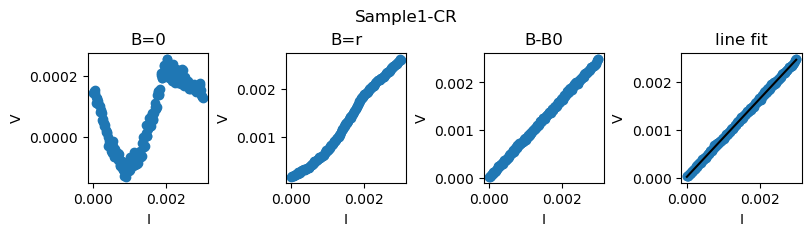

In [54]:
sample1CR = IV_wm('Sample1-CR')
sample1CR.plot()
sample1CR.PrintR()
sample1CR.PrintCarrierDensity()
PrintCarrierMobillity(sample1CR, sample1BC)

R = 1.732e+02 +/- 3.768e-03 ohms
rho = 8.662e-02 +/- 7.098e-09 ohm-m


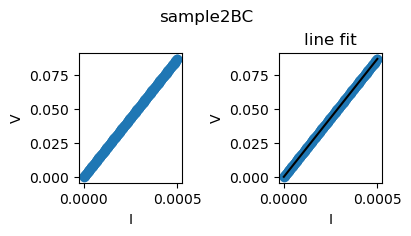

In [55]:
sample2BC = IV_BC('sample2BC')
sample2BC.plot()
sample2BC.PrintR()
sample2BC.PrintResistivity()

R = -3.628e-01 +/- 3.285e-03 ohms
Carrier Density = 1.526e+15 +/- 1.424e+13 cm^-3
Carrier Mobility = 4.722e+02 +/- 1.027e-02 cm^2/Vs


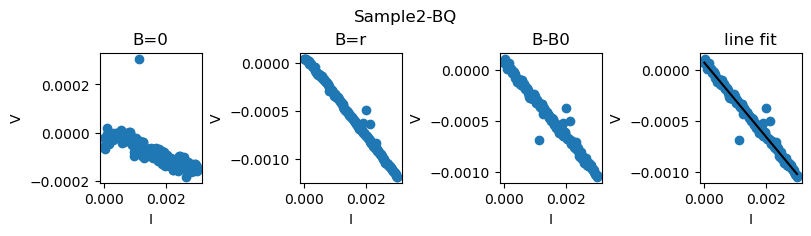

In [56]:
sample2BQ = IV_wm('Sample2-BQ')
sample2BQ.plot()
sample2BQ.PrintR()
sample2BQ.PrintCarrierDensity()
PrintCarrierMobillity(sample2BQ, sample2BC)

R = -3.180e-01 +/- 3.646e-03 ohms
Carrier Density = 1.741e+15 +/- 2.035e+13 cm^-3
Carrier Mobility = 4.138e+02 +/- 9.000e-03 cm^2/Vs


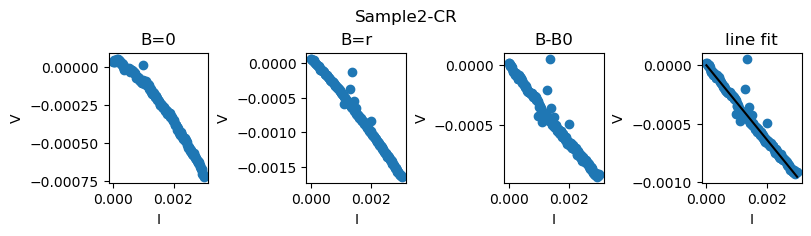

In [57]:
sample2CR = IV_wm('Sample2-CR')
sample2CR.plot()
sample2CR.PrintR()
sample2CR.PrintCarrierDensity()
PrintCarrierMobillity(sample2CR, sample2BC)

In [58]:
def ResistanceLogitudinal():
    names = ['sample1BC', 'sample2BC']
    vals = ['Resistance (Ohms)', 'Resistivity (ohm-m)']
    array = np.empty((2,2), dtype=object)
    for i in range(2):
        array[0,i] = '{0:0.3e} +/- {1:0.3e}'.format(*IV_BC(names[i]).R)
    for i in range(2):
        array[1,i] = '{0:0.3e} +/- {1:0.3e}'.format(*IV_BC(names[i]).resistivity)
    df = pd.DataFrame(array, index=vals, columns=names)
    return df

In [59]:
def ResistanceTransverse():
    names = ['Sample1-BQ', 'Sample1-CR', 'Sample2-BQ', 'Sample2-CR']
    namesb = ['sample1BC', 'sample2BC']
    vals = ['Resistance (Ohms)', 'Carrier Density (cm^-3)', 'Carrier Mobility (cm^2/Vs)']
    array = np.empty((3,4), dtype=object)
    for i in range(4):
        array[0,i] = '{0:0.3e} +/- {1:0.3e}'.format(*IV_wm(names[i]).R)
    for i in range(4):
        array[1,i] = '{0:0.3e} +/- {1:0.3e}'.format(*IV_wm(names[i]).CarrierDensity)
    h = 0
    for i in range(2):
        for j in range(2):
            array[2,h] = '{0:0.3e} +/- {1:0.3e}'.format(*CarrierMobility(IV_wm(names[h]),IV_BC(namesb[i])))
            h += 1
    df = pd.DataFrame(array, index=vals, columns=names)
    return df

In [60]:
def ResistanceTransverseAvg():
    names = ['Sample1-BQ', 'Sample1-CR', 'Sample2-BQ', 'Sample2-CR']
    namesb = ['sample1BC', 'sample2BC']
    array = np.empty((3,2), dtype=object)
    
    h = 0
    for i in range(2):
        x = np.zeros(2)
        y = np.zeros(2)
        array[0,i] = IV_wm(names[i*2]).MobileCarrier
        for j in range(2):
            x += IV_wm(names[h]).CarrierDensity
            y += CarrierMobility(IV_wm(names[h]),IV_BC(namesb[i]))
            h += 1
        array[1,i] = '{0:0.3e} +/- {1:0.3e}'.format(*x/2)
        array[2,i] = '{0:0.3e} +/- {1:0.3e}'.format(*y/2)
    
    df = pd.DataFrame(array, index=['Mobile Carrier', 'Carrier Density Avg (cm^-3)', 'Carrier Mobility Avg (cm^2/Vs)'], columns=['Sample 1', 'Sample 2'])
    return df

In [61]:
ResistanceLogitudinal()

,sample1BC,sample2BC
Resistance (Ohms),8.806e+01 +/- 5.218e-03,1.732e+02 +/- 3.768e-03
Resistivity (ohm-m),4.403e-02 +/- 2.609e-06,8.662e-02 +/- 1.884e-06


In [62]:
ResistanceTransverse()

,Sample1-BQ,Sample1-CR,Sample2-BQ,Sample2-CR
Resistance (Ohms),7.761e-01 +/- 1.526e-03,8.176e-01 +/- 1.452e-03,3.628e-01 +/- 3.285e-03,3.180e-01 +/- 3.646e-03
Carrier Density (cm^-3),7.135e+14 +/- 2.134e+12,6.772e+14 +/- 1.944e+12,1.526e+15 +/- 1.424e+13,1.741e+15 +/- 2.035e+13
Carrier Mobility (cm^2/Vs),1.987e+03 +/- 1.177e-01,2.093e+03 +/- 1.240e-01,4.722e+02 +/- 1.027e-02,4.138e+02 +/- 9.000e-03


In [63]:
ResistanceTransverseAvg()

,Sample 1,Sample 2
Mobile Carrier,Electron,Hole
Carrier Density Avg (cm^-3),6.954e+14 +/- 2.039e+12,1.634e+15 +/- 1.730e+13
Carrier Mobility Avg (cm^2/Vs),2.040e+03 +/- 1.209e-01,4.430e+02 +/- 9.635e-03
